In [1]:
import torch
import onnxruntime

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.image_list import ImageList
from maskrcnn_benchmark.structures.bounding_box import BoxList

from demo.predictor import COCODemo
from demo.utils import load_image
from demo.transform import transform_image

In [2]:
CONFIG_FILE = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"
SAMPLE_IMAGE_PATH = "./sample.jpg"

In [3]:
cfg.merge_from_file(CONFIG_FILE)
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
cfg.freeze()

coco_demo = COCODemo(
    cfg,
    confidence_threshold=0.7,
    min_image_size=800,
)

for param in coco_demo.model.parameters():
    param.requires_grad = False

In [4]:
original_image = load_image(SAMPLE_IMAGE_PATH)
sample_image, t_width, t_height = transform_image(cfg, original_image)
height, width = original_image.shape[:-1]

In [5]:
def ort_run(onnx_io, inputs):
    inputs, _ = torch.jit._flatten(inputs)

    def to_numpy(tensor):
        if tensor.requires_grad:
            return tensor.detach().cpu().numpy()
        else:
            return tensor.cpu().numpy()

    inputs = list(map(to_numpy, inputs))
    
    ort_session = onnxruntime.InferenceSession(onnx_io)

    # compute onnxruntime output prediction
    ort_inputs = dict((ort_session.get_inputs()[i].name, inpt) for i, inpt in enumerate(inputs))
    ort_outs = ort_session.run(None, ort_inputs)

    return ort_outs

In [6]:
onnx_backbone_path = "./onnx_test_models/backbone.onnx"
onnx_rpn_path = "./onnx_test_models/rpn.onnx"

In [7]:
features = ort_run(onnx_backbone_path, (sample_image, ))
features = tuple([torch.tensor(f, dtype=torch.float32) for f in features])

sample_image_list = ImageList(sample_image.unsqueeze(0), [(sample_image.size(-2), sample_image.size(-1))])
expected_features = coco_demo.model.backbone(sample_image_list.tensors)

bbox, objectness = ort_run(onnx_rpn_path, (sample_image, features))
proposals = BoxList(bbox, (t_width, t_height), mode="xyxy")
proposals.add_field("objectenss", objectness)

expected_proposals = coco_demo.model.rpn(sample_image_list, expected_features)[0][0]
expected_proposals = expected_proposals.resize((t_width, t_height))

In [8]:
_, predictions, _ = coco_demo.model.roi_heads(features, [proposals])
_, expected_predictions, _ = coco_demo.model.roi_heads(features, [expected_proposals])

prediction = predictions[0]
prediction = prediction.resize((width, height))
expected_prediction = expected_predictions[0]
expected_prediction = expected_prediction.resize((width, height))

In [9]:
from demo.utils import imshow, masking_image, load_image
result = masking_image(coco_demo, original_image, prediction)
expected_result = masking_image(coco_demo, original_image, expected_prediction)

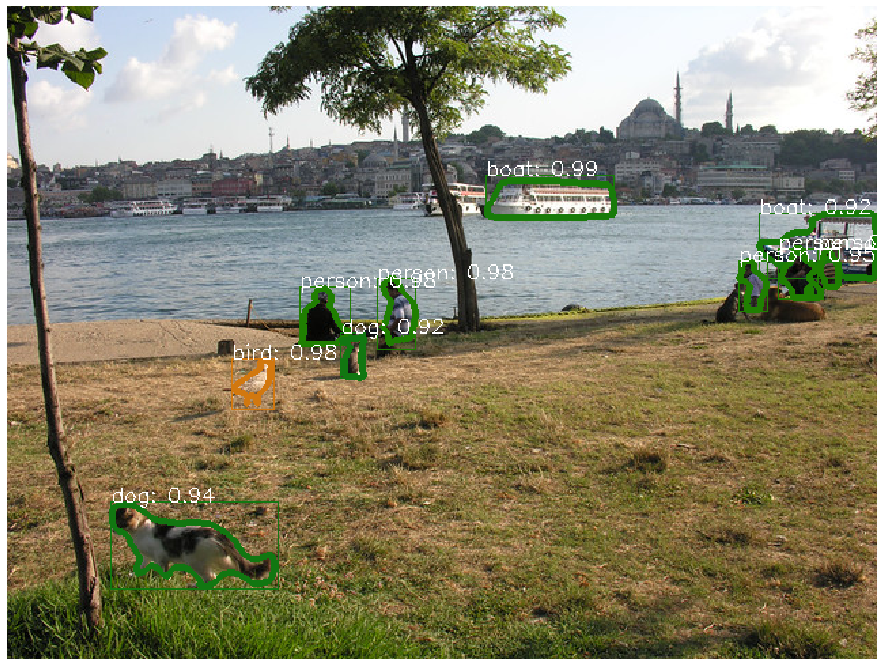

In [10]:
imshow(result)

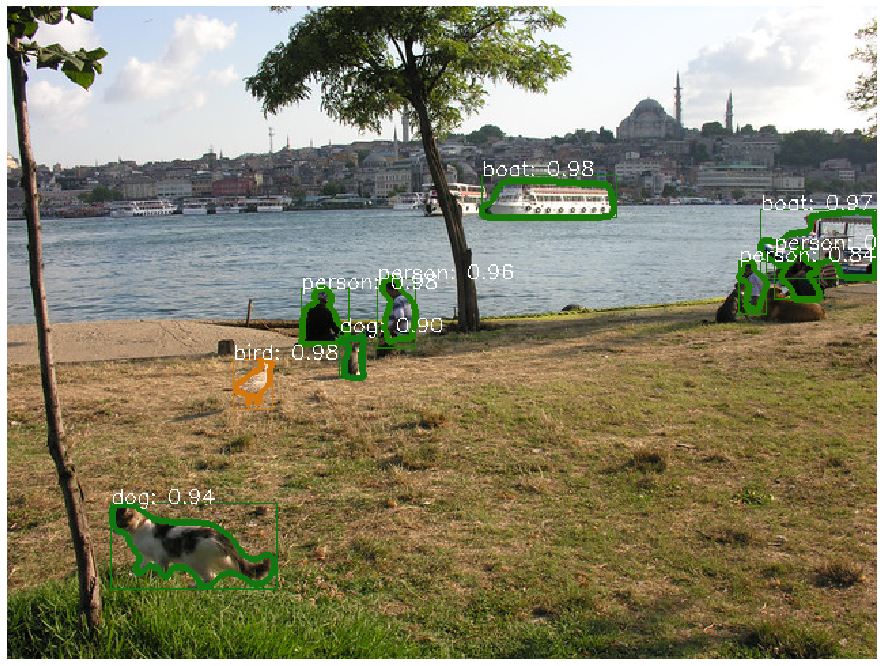

In [11]:
imshow(expected_result)